## Convolutional Neural Networks (CNNs)

In this notebook, we will learn to use pytorch's autograd. We will not be implementing gradient computations anymore. First, we will re-implement FashionMNIST Classification using pytorch. Then we will perform FashionMNIST Classification using the LeNet convolutional neural network. We will also be using GPUs for the first time to accelerate computations.


### 1. Using the GPU with pytorch


This code will show you how easy is to do GPU computations in pytorch, and how fast they can be. Note that the first time you run this code there might be some delay in starting up the GPU, so it might actually be slower, so try running this cell multiple times.

In [1]:
import torch
import time

# Let's create two matrices of size dxd and full of random values.
d = 5000
a = torch.rand(d, d)
b = torch.rand(d, d)

# Compute a multiplication between the two matrices in CPU.
start_time = time.time()
output = torch.mm(a, b)  # Regular multiplication in CPU.
cpu_time = time.time() - start_time
print('CPU-time {0:.6f}s'.format(cpu_time))

# Compute a multiplication between the two matrices in GPU.
start_time = time.time()
a = a.cuda()  # Move to GPU.
b = b.cuda()  # Move to GPU.
output = torch.mm(a, b)  # Multiplication happens in GPU.
gpu_time = time.time() - start_time
print('GPU-time {0:.6f}s\n'.format(gpu_time))

print('CPU was {0:.2f}x times the GPU time'.format(cpu_time / gpu_time))

CPU-time 0.606379s
GPU-time 2.667869s

CPU was 0.23x times the GPU time


Trry experimenting with different values of $d$ and check what kind of improvements in the speed you can get on GPU compared to CPU.

### 2. Mini-batch SGD on FashionMNIST using pytorch nn's package.


#### 2.1 Defining a model in Pytorch


In this section we will train a two-layer neural network using pytorch's nn package. First, we will define, the model and its operations. Then we will train the model using mini-batch gradient descent. Note that we don't need to train a backward pass function anymore. Pytorch as backward pass functions implemented for nn.Linear and F.relu AND keeps track of operations in a dynamic computation graph, so as long as you execute chains of operations supported by Pytorch your backward pass does not need to be implemented.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TwoLayerNN(nn.Module):
    def __init__(self):
        super(TwoLayerNN, self).__init__()

        self.linear1 = nn.Linear(1 * 28 * 28, 512)
        self.linear2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 1 * 28 * 28)
        z = F.relu(self.linear1(x))
        return self.linear2(z)


# Using TwoLayerNN:
# Let's create a dummy batch tensor with 16 input vectors.
dummy_input = torch.zeros(16, 1 * 28 * 28)
my_model = TwoLayerNN()
dummy_output = my_model(dummy_input)

print('Input size (16 input vectors):', dummy_input.shape)
print('Output size (16 output predictions):', dummy_output.shape)

Input size (16 input vectors): torch.Size([16, 784])
Output size (16 output predictions): torch.Size([16, 10])


#### 2.2 Manipulating gradients in Pytorch.




I will elaborate here some more about Pytorch's approach to creating the computational graph and storing gradients. First, each tensor can store its gradient in the .grad property of the tensor variable, and each tensor also keeps track of the last operation that was applied to it. In this way a tensor can backpropagate gradients to the previous operator and store its own gradients in the same variable. An example of this is presented below:

In [10]:
x = torch.tensor([[1, 0], [-2, -1]], dtype=torch.float, requires_grad=True)

v = torch.tensor([[1, 1], [1, 1]], dtype=torch.float, requires_grad=True)

z = torch.tensor([[-3, -1], [-3, -3]], dtype=torch.float, requires_grad=True)

y = ((x + v) * z).sum()

# Let's print the output y.
# Notice how the tensor y also has grad_fn = <SumBackward0>.
# This is tracking the last operation that led up to y, which is a sum.
# SumBackward0 is the backward pass for a sum operation.
print('y = ', y)

# Now let's compute dy / dx
# This computes the gradients leading up to the scalar value y.
# No matter how far back was x in the computation that led to the y value.
y.backward()

print('x = ', x)
print('dy / dx = ', x.grad)
# If you try printing x.grad before calling y.backward() it probably
# had nothing there.

y =  tensor(-4., grad_fn=<SumBackward0>)
x =  tensor([[ 1.,  0.],
        [-2., -1.]], requires_grad=True)
dy / dx =  tensor([[-3., -1.],
        [-3., -3.]])


#### 2.3 Training a model in Pytorch

The training code is similar to the code used before but notice several simplifications and the generality of this code. For instance, we don't need to pass gradients ourselves layer by layer. Only one call to backward() is needed,  because this will compute gradients for all the tensors tha led up to the value of the loss.

In [11]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import torch.optim as optim

# Removes, the need to call F.to_image ourselves.
transform = transforms.Compose([transforms.ToTensor()])

# Load the training, and validation datasets.
trainset = FashionMNIST(root='./data',
                        train=True,
                        transform=transform,
                        download=True)
valset = FashionMNIST(root='./data',
                      train=False,
                      transform=transform,
                      download=True)

# Pytorch DataLoader for iterating over batches.
batchSize = 100

# Create the model.
model = TwoLayerNN()
loss_fn = nn.CrossEntropyLoss()

# Define a learning rate.
learningRate = 5e-2

# Optimizer.
optimizer = optim.SGD(model.parameters(),
                      lr=learningRate,
                      momentum=0.9,
                      weight_decay=1e-4)


def train_model(model, loss_fn, batchSize, trainset, valset, optimizer,
                num_epochs):

    # Shuffling is needed in case dataset is not shuffled by default.
    train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                               batch_size=batchSize,
                                               shuffle=True)
    # We don't need to bach the validation set but let's do it anyway.
    val_loader = torch.utils.data.DataLoader(dataset=valset,
                                             batch_size=batchSize,
                                             shuffle=False)  # No need.

    # Define number of epochs.
    N = num_epochs

    # log accuracies and losses.
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # GPU enabling.
    model = model.cuda(device=0)
    loss_fn = loss_fn.cuda(device=0)

    # Training loop. Please make sure you understand every single line of code below.
    # Go back to some of the previous steps in this lab if necessary.
    for epoch in range(0, N):
        correct = 0.0
        cum_loss = 0.0

        # Make a pass over the training data.
        model.train()
        for (i, (inputs, labels)) in enumerate(train_loader):
            inputs = inputs.cuda(device=0)
            labels = labels.cuda(device=0)

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            loss = loss_fn(scores, labels)

            # Count how many correct in this batch.
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == labels).sum().item()
            cum_loss += loss.item()

            # Zero the gradients in the network.
            optimizer.zero_grad()

            #Backward pass. (Gradient computation stage)
            loss.backward()

            # Parameter updates (SGD step) -- if done with torch.optim!
            optimizer.step()

            # Parameter updates (SGD step) -- if done manually!
            # for param in model.parameters():
            #   param.data.add_(-learningRate, param.grad)

            # Logging the current results on training.
            if (i + 1) % 100 == 0:
                print(
                    'Train-epoch %d. Iteration %05d / %05d, Avg-Loss: %.4f, Accuracy: %.4f'
                    % (epoch, i + 1, len(train_loader), cum_loss /
                       (i + 1), correct / ((i + 1) * batchSize)))

        train_accuracies.append(correct / len(trainset))
        train_losses.append(cum_loss / (i + 1))

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        model.eval()
        for (i, (inputs, labels)) in enumerate(val_loader):
            inputs = inputs.cuda(device=0)
            labels = labels.cuda(device=0)

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            cum_loss += loss_fn(scores, labels).item()

            # Count how many correct in this batch.
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == labels).sum().item()

        val_accuracies.append(correct / len(valset))
        val_losses.append(cum_loss / (i + 1))

        # Logging the current results on validation.
        print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' %
              (epoch, cum_loss / (i + 1), correct / len(valset)))

In [5]:
train_model(model, loss_fn, batchSize, trainset, valset, optimizer, 5)

Train-epoch 0. Iteration 00100 / 00600, Avg-Loss: 0.8745, Accuracy: 0.6883
Train-epoch 0. Iteration 00200 / 00600, Avg-Loss: 0.7011, Accuracy: 0.7518
Train-epoch 0. Iteration 00300 / 00600, Avg-Loss: 0.6354, Accuracy: 0.7758
Train-epoch 0. Iteration 00400 / 00600, Avg-Loss: 0.5933, Accuracy: 0.7896
Train-epoch 0. Iteration 00500 / 00600, Avg-Loss: 0.5610, Accuracy: 0.8014
Train-epoch 0. Iteration 00600 / 00600, Avg-Loss: 0.5413, Accuracy: 0.8085
Validation-epoch 0. Avg-Loss: 0.4426, Accuracy: 0.8375
Train-epoch 1. Iteration 00100 / 00600, Avg-Loss: 0.4025, Accuracy: 0.8522
Train-epoch 1. Iteration 00200 / 00600, Avg-Loss: 0.3953, Accuracy: 0.8534
Train-epoch 1. Iteration 00300 / 00600, Avg-Loss: 0.3951, Accuracy: 0.8543
Train-epoch 1. Iteration 00400 / 00600, Avg-Loss: 0.3947, Accuracy: 0.8559
Train-epoch 1. Iteration 00500 / 00600, Avg-Loss: 0.3951, Accuracy: 0.8556
Train-epoch 1. Iteration 00600 / 00600, Avg-Loss: 0.3937, Accuracy: 0.8562
Validation-epoch 1. Avg-Loss: 0.4030, Accurac

We achieved an accuracy of 86% and achieved 84% in only one epoch. Our model is very similar to the models we implemented before, but now we are using SGD with regularization (weightDecay), and momentum updates (using the history of previous gradients) in order to update the parameters. We also have generic train_model function that is independent of the model passed as a parameter. We no longer need to focus on this training loop, and instead can concentrate in the design of model architectures. 

### 3. Convolutional Neural Network -- LeNet


Now let's implement our first convolutional neural network using Pytorch's nn.Conv2d. It is essential that you understand to a high level of detail what Conv2d does, given a certain the shape of a given input tensor, what will be the shape of the output tensor? what is the size of the weight and bias parameters? You should know answers to these questions. Do not continue until you're sure.

In [3]:
# Insipired on LeNet, first proposed in:
# https://ieeexplore.ieee.org/abstract/document/726791
# PDF: http://www.cs.virginia.edu/~vicente/deeplearning/readings/lecun1998.pdf
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # Convolutional layers.
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)

        # Linear layers.
        self.fc1 = nn.Linear(64 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Conv1 + ReLU + MaxPooling.
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)

        # Conv2 + ReLU + MaPooling.
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)

        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1)

        # Linear layer + ReLU.
        out = F.relu(self.fc1(out))
        # Linear layer + ReLU.
        out = F.relu(self.fc2(out))
        # A final linear layer at the end.
        out = self.fc3(out)

        # We will not add Softmax here because nn.CrossEntropy does it.
        # Read the documentation for nn.CrossEntropy.
        return out



In [7]:
cnn_model = LeNet()

# print(cnn_model) # It shows the network structure.

# see: ADAM: A Method for Stochastic Optimization.
# This is a variant of SGD that makes adaptive step updates.
# https://arxiv.org/pdf/1412.6980.pdf
optimizer = optim.Adam(cnn_model.parameters(), lr=3e-3)

train_model(cnn_model, loss_fn, batchSize, trainset, valset, optimizer, 5)

Train-epoch 0. Iteration 00100 / 00600, Avg-Loss: 0.9125, Accuracy: 0.6568
Train-epoch 0. Iteration 00200 / 00600, Avg-Loss: 0.7450, Accuracy: 0.7183
Train-epoch 0. Iteration 00300 / 00600, Avg-Loss: 0.6627, Accuracy: 0.7511
Train-epoch 0. Iteration 00400 / 00600, Avg-Loss: 0.6038, Accuracy: 0.7740
Train-epoch 0. Iteration 00500 / 00600, Avg-Loss: 0.5615, Accuracy: 0.7906
Train-epoch 0. Iteration 00600 / 00600, Avg-Loss: 0.5291, Accuracy: 0.8031
Validation-epoch 0. Avg-Loss: 0.3707, Accuracy: 0.8640
Train-epoch 1. Iteration 00100 / 00600, Avg-Loss: 0.3344, Accuracy: 0.8768
Train-epoch 1. Iteration 00200 / 00600, Avg-Loss: 0.3380, Accuracy: 0.8752
Train-epoch 1. Iteration 00300 / 00600, Avg-Loss: 0.3301, Accuracy: 0.8796
Train-epoch 1. Iteration 00400 / 00600, Avg-Loss: 0.3264, Accuracy: 0.8816
Train-epoch 1. Iteration 00500 / 00600, Avg-Loss: 0.3242, Accuracy: 0.8822
Train-epoch 1. Iteration 00600 / 00600, Avg-Loss: 0.3209, Accuracy: 0.8826
Validation-epoch 1. Avg-Loss: 0.3362, Accurac

Now we have a working model that classifies images at ~90% accuracy. Moreover, this simple convolutional neural network often matches the accuracy of the shallow linear classifier on the very first epoch.

You can find a list of results that people have obtained on FashionMNIST using more sophisticated neural networks here, including some accuracies slightly above 95%: https://github.com/zalandoresearch/fashion-mnist

### 4. Using a Pre-Trained Convolutional Neural Network -- Resnet-50



In this section we will load a network pretrained on the ImageNet ILSVRC dataset, which has RGB images annotated with one label out of a vocabulary 1000 categories, and use it to make predictions on new images. We will use the Resnet-50 neural network proposed by a team at Microsoft Research around 2015-2016.

In [4]:
import torchvision.models as models

# Download list of 1000 categories for the ILSVRC task in right order.
#!wget -nc -q http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
#wget.download('http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json')
#Load the pre-trained model from the torchvision package.

# https://arxiv.org/abs/1512.00567  # Re-thinking the Inception Architecture.
#cnn_model = models.inception_v3(pretrained = True)

# https://arxiv.org/abs/1512.03385 # Residual Networks.
cnn_model = models.resnet50(pretrained = True)

cnn_model.eval();  # Set in evaluation mode! In this case it matters.

# print(resnet) # It shows the network structure.
# You should instead look at source code here:
# https://pytorch.org/docs/stable/_modules/torchvision/models/inception.html#inception_v3

Now we will use the model, but we have to be careful to use the exact same pre-processing steps for the input as it was done during training. I am providing the code here below that pre-processes images in the same way as this model was trained.

(-0.5, 531.5, 537.5, -0.5)

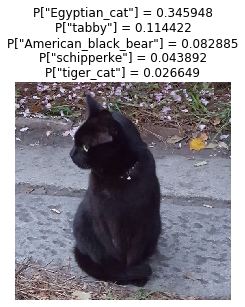

In [6]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json, io, requests, string

# 1. Define the appropriate image pre-processing function.
# This has to be the preprocessing function used during training.
preprocessFn = transforms.Compose([
    transforms.Resize(256),  # 1. Resize smallest side to 256.
    transforms.CenterCrop(224),  # 2. Crop the center 224x224 pixels.
    transforms.ToTensor(),  # 3. Convert to pytorch tensor.
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # normalize.
        std=[0.229, 0.224, 0.225])
])

# 2. Load the imagenet class names.
imagenetClasses = {
    int(idx): entry[1]
    for (idx, entry) in json.load(open('imagenet_class_index.json')).items()
}

# 3. Read image from URL into a PIL image type.
# This is a picture of a cat I took at the
# Edgar Allan Poe's museum in Richmond, VA.
# Try other images!
img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
input_img = preprocessFn(img_pil).unsqueeze(0)
predictions = cnn_model(input_img)

# 5. Decode the top 5 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim=1).data).sort()
probs = (-probs).numpy()[0][:5]
indices = indices.numpy()[0][:10]
preds = ['P[\"' + imagenetClasses[idx] + '\"] = ' + ('%.6f' % prob) \
         for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img_pil)
plt.grid(False)
plt.axis('off')

### 5. Fine-tuning a Pre-trained Model for a Different Task (and Dataset) 



Pre-trained models can be adapted to other tasks, by lightly re-training them (with a small learning rate), and replacing some of the last layers with custom layers for a different task. This process is usually referred as fine-tuning a network, and is the usual way of using neural networks for many applications. In this assignment we will be using the MIT Indoor Scenes Dataset introduced at CVPR 2009 http://web.mit.edu/torralba/www/indoor.html. This dataset has more than 15 thousand images belonging to 67 categories of indoor scenes (e.g. meeting room, dining room, toy store, restaurant, etc). 


#### 5.1 Downloading the Data - Indoor Place Recognition




When the MIT researchers Ariadna Quattoni and Antonio Torralba performed this work, they only used 67 \* 80 = 5360 images for training, and 67 \* 20 = 1340 images for testing, but we will use all the images instead. The tar file with all the images is about 2.4GB but we already downloaded, resized and cropped images to a 256x256 resolution for a total of 235MB. We also separated the images into three groups MIT-test, which is the same test data used in the original work, and [train-uva.tar.gz](https://www.cs.virginia.edu/~vicente/deeplearning/train-uva.tar.gz), [val-uva.tar.gz](https://www.cs.virginia.edu/~vicente/deeplearning/val-uva.tar.gz) which are the rest of the images sub-divided into training and validation sets. We will not use the MIT-test images as this is the test set, so I am not providing the test images at all. The images inside these tar-files were already arranged in the format required to use the [torchvision.datasets.ImageFolder](https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder) class.

In [10]:
# First download the data files.
# !wget -nc https://www.cs.virginia.edu/~vicente/deeplearning/MIT-indoor-val-uva.tar.gz
# !wget -nc https://www.cs.virginia.edu/~vicente/deeplearning/MIT-indoor-train-uva.tar.gz
# !tar xf MIT-indoor-val-uva.tar.gz
# !tar xf MIT-indoor-train-uva.tar.gz
# !ls -lh

# #!pip install wget
# import wget
# wget.download('https://www.cs.virginia.edu/~vicente/deeplearning/MIT-indoor-val-uva.tar.gz')
# wget.download('https://www.cs.virginia.edu/~vicente/deeplearning/MIT-indoor-train-uva.tar.gz')


#### 5.2 Setting up Data Loaders with Data Augmentation


We often want to apply different transformations during training compared to testing to augment the data during training. In pytorch we can achieve this with minimal modifications by specifying a slightly different transformation function during training. However, one has to be careful that both training and testing images are subject to similar transformations.

(-0.5, 255.5, 255.5, -0.5)

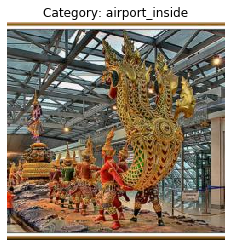

In [12]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

train_transform = transforms.Compose([
    transforms.Resize(256),  # 1. Resize smallest side to 256.
    #transforms.RandomCrop(224),  # 2. Crop random square of 224x224 pixels.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # 3. Convert to pytorch tensor.
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # normalize.
        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),  # 1. Resize smallest side to 256.
    #transforms.CenterCrop(224),  # 2. Crop center square of 224x224 pixels.
    transforms.ToTensor(),  # 3. Convert to pytorch tensor.
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # normalize.
        std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("train-uva", train_transform)
val_dataset = datasets.ImageFolder("val-uva", test_transform)

# Try seeing other images in this dataset.
# If you run this cell multiple times, you will perhaps notice
# that the images are indeed slightly shifted (due to random cropping),
# or they are mirrored (due to the horizonal flipping).
# Only for the train_dataset this will happen.
my_image, my_label = train_dataset[100]

# Show the image and its label.

plt.figure()
plt.title("Category: " + train_dataset.classes[my_label])
# Undo normalization of the pixel values.
for t, m, s in zip(my_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
    t.mul_(s).add_(m)
# Re-arrange dimensions so it is height x width x channels.
plt.imshow(my_image.transpose(0, 2).transpose(0, 1))
plt.grid(False)
plt.axis('off')

#### 5.3 Fine-tuning Resnet-50 for the Indoor Scene Classification task.

In this section we will take the Resnet-50 network and "fine-tune" it to the task of Indoor Scene Classification. First, we proceed to replace the last layer in resnet50 with a linear layer that outputs 67 numbers corresponding to the categories on the MIT Indoor scene recognition dataset.

In [13]:
import torchvision.models as models
import torch.nn as nn

scene_model = models.resnet50(pretrained = True)
# print(cnn_model) # Print the model to see what you can modify. 
# We are modifying the last layer which is stored in the fc property
# for this model as you can see by printing out the network.
print(scene_model)
scene_model.fc = nn.Linear(2048, len(train_dataset.classes))
# print(cnn_model)  # Verify that the last linear layer was changed.
print(scene_model)
#scene_model.cuda()
pytorch_total_params = sum(p.numel() for p in scene_model.parameters())
pytorch_total_params

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

)


23645315

Now let's proceed to train this model with our dataset.

In [14]:
import torch.optim as optim

batchSize = 24 #Reduce or memory issues
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(scene_model.parameters(), lr = 3e-4, momentum = 0.9, weight_decay=1e-5)

train_model(scene_model, loss_fn, batchSize, train_dataset, val_dataset, optimizer, 10)

# Save your model weights after training in case you need to load them later.
torch.save(scene_model.state_dict(), 'scene_model_weights.pth')
# If you are working on Google Cloud, make sure to download this file.

Train-epoch 0. Iteration 00100 / 00540, Avg-Loss: 3.9060, Accuracy: 0.1125
Train-epoch 0. Iteration 00200 / 00540, Avg-Loss: 3.6784, Accuracy: 0.1737
Train-epoch 0. Iteration 00300 / 00540, Avg-Loss: 3.4752, Accuracy: 0.2332
Train-epoch 0. Iteration 00400 / 00540, Avg-Loss: 3.2999, Accuracy: 0.2771
Train-epoch 0. Iteration 00500 / 00540, Avg-Loss: 3.1524, Accuracy: 0.3083
Validation-epoch 0. Avg-Loss: 3.2476, Accuracy: 0.2500
Train-epoch 1. Iteration 00100 / 00540, Avg-Loss: 2.2226, Accuracy: 0.4838
Train-epoch 1. Iteration 00200 / 00540, Avg-Loss: 2.1250, Accuracy: 0.5058
Train-epoch 1. Iteration 00300 / 00540, Avg-Loss: 2.0539, Accuracy: 0.5185
Train-epoch 1. Iteration 00400 / 00540, Avg-Loss: 2.0034, Accuracy: 0.5273
Train-epoch 1. Iteration 00500 / 00540, Avg-Loss: 1.9497, Accuracy: 0.5364
Validation-epoch 1. Avg-Loss: 2.3672, Accuracy: 0.3873
Train-epoch 2. Iteration 00100 / 00540, Avg-Loss: 1.5550, Accuracy: 0.6208
Train-epoch 2. Iteration 00200 / 00540, Avg-Loss: 1.5196, Accurac

Is the model working? Accuracy looks good but let's see some predictions! Never forget to see your predictions, don't just look at numbers to assess if something is working.

(-0.5, 255.5, 255.5, -0.5)

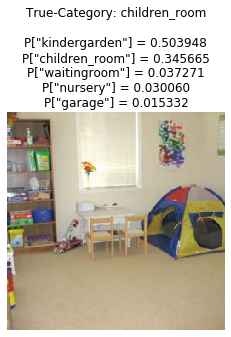

In [15]:
# Try seeing other images in this dataset.
# If you run this cell multiple times, you will perhaps notice
# that the images are indeed slightly shifted (due to random cropping),
# or they are mirrored (due to the horizonal flipping).
# Only for the train_dataset this will happen.
my_image, my_label = val_dataset[231]

scene_model.eval()
# Load weights from file if needed.
# scene_model.load_state_dict(torch.load('scene_model_weights.pth'))
predictions = scene_model(my_image.cuda().unsqueeze(0))

preds = predictions.data.cpu().softmax(dim=1)
probs, indices = (-preds).sort()
probs = (-probs).numpy()[0][:5]
indices = indices.numpy()[0][:5]
preds = ['P[\"' + val_dataset.classes[idx] + '\"] = ' + ('%.6f' % prob) \
         for (prob, idx) in zip(probs, indices)]

# Show the image and its label.
plt.figure()
plt.title("True-Category: " + val_dataset.classes[my_label] + "\n\n" +
          "\n".join(preds))
# Undo normalization of the pixel values.
for t, m, s in zip(my_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
    t.mul_(s).add_(m)
# Re-arrange dimensions so it is height x width x channels.
plt.imshow(my_image.transpose(0, 2).transpose(0, 1))
plt.grid(False)
plt.axis('off')

### 6. Using a Pretrained network as a feature extractor




Instead of finetuning a cheaper option which tends to be equally effective for small datasets is to use the pretrained network to compute some output features. Typically the outputs of the network before the classification layer. In this way, we only train the last layer and do not backpropagate to the previous layers. We could also precompute features for each image but this prevents us from using data augmentation.

#### 6.1 First, let's define the feature extractor

In [15]:
import torchvision.models as models
import torch.nn as nn

# Load the pretrained ResNet model.
resnet_model = models.resnet50(pretrained=True)


# Throw away the layer that does classification on this model (the last layer).
# Then discard the height and width dimensions using tensor.view.
class FeatureExtractor(nn.Module):
    def __init__(self, resnet_model):
        super(FeatureExtractor, self).__init__()
        self.truncated_resnet = nn.Sequential(
            *list(resnet_model.children())[:-1]).cuda()

    def forward(self, x):
        feats = self.truncated_resnet(x)
        return feats.view(feats.size(0), -1)


# Let's test the feature extractor to see what size are the outputs
# right before the layer we eliminated.
feature_extractor = FeatureExtractor(resnet_model)
dummy_inputs = torch.zeros(10, 3, 224, 224).cuda()
dummy_outputs = feature_extractor(dummy_inputs)
print(dummy_outputs.shape)

torch.Size([10, 2048])


#### 6.2 Now let's reimplement our train_model function to use a feature extractor. 
It requires changing our previous code in two or three places only.

In [16]:
def train_model_2(model, feature_extractor, loss_fn, batchSize, trainset,
                  valset, optimizer, num_epochs):

    # Shuffling is needed in case dataset is not shuffled by default.
    train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                               batch_size=batchSize,
                                               shuffle=True)
    # We don't need to bach the validation set but let's do it anyway.
    val_loader = torch.utils.data.DataLoader(dataset=valset,
                                             batch_size=batchSize,
                                             shuffle=False)  # No need.

    # Define number of epochs.
    N = num_epochs

    # log accuracies and losses.
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # GPU enabling.
    model = model.cuda()
    loss_fn = loss_fn.cuda()

    # feature extractor does not need training.
    feature_extractor.eval()

    # Training loop. Please make sure you understand every single line of code below.
    # Go back to some of the previous steps in this lab if necessary.
    for epoch in range(0, N):
        correct = 0.0
        cum_loss = 0.0

        # Make a pass over the training data.
        model.train()
        for (i, (inputs, labels)) in enumerate(train_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Forward pass. (Prediction stage)
            with torch.no_grad():
                features = feature_extractor(inputs)
            scores = model(features)
            loss = loss_fn(scores, labels)

            # Count how many correct in this batch.
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == labels).sum().item()
            cum_loss += loss.item()

            # Zero the gradients in the network.
            optimizer.zero_grad()

            #Backward pass. (Gradient computation stage)
            loss.backward()

            # Parameter updates (SGD step) -- if done with torch.optim!
            optimizer.step()

            # Parameter updates (SGD step) -- if done manually!
            # for param in model.parameters():
            #   param.data.add_(-learningRate, param.grad)

            # Logging the current results on training.
            if (i + 1) % 100 == 0:
                print(
                    'Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f'
                    % (epoch, i + 1, cum_loss / (i + 1), correct /
                       ((i + 1) * batchSize)))

        train_accuracies.append(correct / len(trainset))
        train_losses.append(cum_loss / (i + 1))

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        model.eval()
        for (i, (inputs, labels)) in enumerate(val_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Forward pass. (Prediction stage)
            with torch.no_grad():
                features = feature_extractor(inputs)
                scores = model(features)
                cum_loss += loss_fn(scores, labels).item()

            # Count how many correct in this batch.
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == labels).sum().item()

        val_accuracies.append(correct / len(valset))
        val_losses.append(cum_loss / (i + 1))

        # Logging the current results on validation.
        print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' %
              (epoch, cum_loss / (i + 1), correct / len(valset)))

#### 6.3 Now let's train and see what happens.

In [17]:
batchSize = 20
loss_fn = nn.CrossEntropyLoss()

# Define the model (we will just train a linear layer).
linear_scene_model = nn.Linear(2048, len(train_dataset.classes))
optimizer = optim.SGD(linear_scene_model.parameters(), lr = 1e-3, momentum = 0.9, weight_decay=1e-5)

# Train the model.
train_model_2(linear_scene_model, feature_extractor, loss_fn, batchSize, train_dataset, val_dataset, optimizer, 10)

Train-epoch 0. Iteration 00100, Avg-Loss: 3.3981, Accuracy: 0.2395
Train-epoch 0. Iteration 00200, Avg-Loss: 2.9313, Accuracy: 0.3445
Train-epoch 0. Iteration 00300, Avg-Loss: 2.6605, Accuracy: 0.3973
Train-epoch 0. Iteration 00400, Avg-Loss: 2.4743, Accuracy: 0.4334
Train-epoch 0. Iteration 00500, Avg-Loss: 2.3186, Accuracy: 0.4651
Train-epoch 0. Iteration 00600, Avg-Loss: 2.1859, Accuracy: 0.4901
Validation-epoch 0. Avg-Loss: 2.1076, Accuracy: 0.4239
Train-epoch 1. Iteration 00100, Avg-Loss: 1.4436, Accuracy: 0.6370
Train-epoch 1. Iteration 00200, Avg-Loss: 1.3906, Accuracy: 0.6475
Train-epoch 1. Iteration 00300, Avg-Loss: 1.3686, Accuracy: 0.6530
Train-epoch 1. Iteration 00400, Avg-Loss: 1.3414, Accuracy: 0.6581
Train-epoch 1. Iteration 00500, Avg-Loss: 1.3178, Accuracy: 0.6629
Train-epoch 1. Iteration 00600, Avg-Loss: 1.3011, Accuracy: 0.6653
Validation-epoch 1. Avg-Loss: 1.6231, Accuracy: 0.5373
Train-epoch 2. Iteration 00100, Avg-Loss: 1.1295, Accuracy: 0.7140
Train-epoch 2. Iter

## Assignment Questions [100pts]

### 1. Fine-tuning for Multi-label classification [40pts]: 


Fine-tune the Alexnet or Resnet-50 model for the task of multi-label classification where the output scores are not mutually exclusve. You are going to use a subset of the COCO dataset which I provide for you. I already wrote a dataloader for you so you don't need to worry about this part. For grading, provide 1) a training/validation plot for a) losses and b) the accuracy of the top-3 predicted labels per image, and  2) Show examples along with their predictions showcasing that your model is indeed making reasonable predictions, 3) Use data augmentation, at least random horizontal flips during training. Your predictions are not mutually exclusive, e.g. an output score of 0.9 for dog and 0.9 for cat should be possible because the output scores should not be forced to sum to 1.

#### Download COCO Images.

You can use the images from the cocodataset.org official distribution which is 20GB in size or you can download my file coco_images_small.zip which is only 2GB. They both have the same images but I already resized them so that they are 256 pixels max either in their length or width.

In [15]:
# Stored all data locally
# wget.download('http://images.cocodataset.org/annotations/annotations_trainval2014.zip')
# wget.download('http://www.cs.virginia.edu/~vicente/deeplearning/coco_images_small.zip')

'coco_images_small.zip'

#### Data Loader Definition

In [17]:
import torch.utils.data
import json, os
from PIL import Image
import torchvision.transforms as transforms


class CocoMultilabel(torch.utils.data.Dataset):
    def __init__(self, image_path, annotation_filepath, transform=None):
        super(CocoMultilabel, self).__init__()

        print('Loading data...')
        data = json.load(open(annotation_filepath, 'rb'))

        self.transform = transform
        self.image_path = image_path

        # I like storing sorted for consistency across runs.
        paired_id_names = [(image['id'], image['file_name'])
                           for image in data['images']]
        paired_id_names = sorted(paired_id_names, key=lambda x: x[0])
        self.image_names = [img_name for (img_id, img_name) in paired_id_names]
        self.image_ids = [img_id for (img_id, img_name) in paired_id_names]

        # Also storing sorted for consistency across runs.
        # I don't want student A have 'dog' as class[0] and student be as class[1].
        paired_id_names = [(category['id'], category['name'])
                           for category in data['categories']]
        paired_id_names = sorted(paired_id_names, key=lambda x: x[0])
        self.classes = [cat_name for (cat_id, cat_name) in paired_id_names]
        classes_ids = [cat_id for (cat_id, cat_name) in paired_id_names]
        class_id_to_index = {
            category_id: i
            for (i, category_id) in enumerate(classes_ids)
        }

        # Map images to annotations.
        image_anns = dict()
        for ann in data['annotations']:
            if ann['image_id'] not in image_anns:
                image_anns[ann['image_id']] = set()
            image_anns[ann['image_id']].add(ann['category_id'])

        # Precompute labels as 1-0 vectors.
        self.image_labels = torch.zeros(len(self.image_ids), len(self.classes))
        for (i, image_id) in enumerate(self.image_ids):
            if image_id in image_anns:  # Apparently some images have no labels.
                anns = list(image_anns[image_id])
                anns = torch.tensor(
                    [class_id_to_index[cat_id] for cat_id in anns])
                self.image_labels[i, anns] = 1

        print('...loaded.')

    def __getitem__(self, index):
        image_name = self.image_names[index]
        img_ = Image.open(open(os.path.join(self.image_path, image_name),
                               'rb'))
        img_ = img_.convert("RGB")
        if self.transform:
            img_ = self.transform(img_)
        label_ = self.image_labels[index, :]
        return img_, label_, image_name

    def __len__(self):
        return len(self.image_ids)


# You can unnormalize the transformation of torch's transforms.normalize
# with this custom transformation.
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [18]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

#Data Augmentation
#Random Crops and Flips During Training
train_transform = transforms.Compose([
    transforms.Resize((256,256)),  # 1. Resize smallest side to 256.
    #transforms.RandomCrop(224),  # 2. Crop random square of 224x224 pixels.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # 3. Convert to pytorch tensor.
    transforms.Normalize(
       mean=[0.485, 0.456, 0.406],  # normalize.
       std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),  # 1. Resize smallest side to 256.
    #transforms.CenterCrop(224),  # 2. Crop center square of 224x224 pixels.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # 3. Convert to pytorch tensor.
    transforms.Normalize(
       mean=[0.485, 0.456, 0.406],  # normalize.
       std=[0.229, 0.224, 0.225])
])

In [19]:
augmentation = True
if augmentation:
    train_dataset = CocoMultilabel('coco_256x256/train',
                                   'annotations/instances_train2014.json',
                                   transform=train_transform)
    val_dataset = CocoMultilabel('coco_256x256/val',
                             'annotations/instances_val2014.json', transform=test_transform)
    
else:
    train_dataset = CocoMultilabel('coco_256x256/train',
                                   'annotations/instances_train2014.json')

    val_dataset = CocoMultilabel('coco_256x256/val',
                                 'annotations/instances_val2014.json')
    
len(train_dataset.image_names)
len(val_dataset.image_names)

print('-' * 50)
print(f'Size of trainset = {len(train_dataset.image_names)}')
print(f'Size of valset = {len(val_dataset.image_names)}')
print('-' * 50)
print(f'Number of Classes (train) = {len(train_dataset.classes)}')
print(f'Number of Classes (val)= {len(val_dataset.classes)}')

# #check dims
# for i in range(len(train_dataset)):
#     assert train_dataset[i][0].size() == train_dataset[i+1][0].size(), 'size mismatch'

Loading data...
...loaded.
Loading data...
...loaded.
--------------------------------------------------
Size of trainset = 82783
Size of valset = 40504
--------------------------------------------------
Number of Classes (train) = 80
Number of Classes (val)= 80


(-0.5, 255.5, 255.5, -0.5)

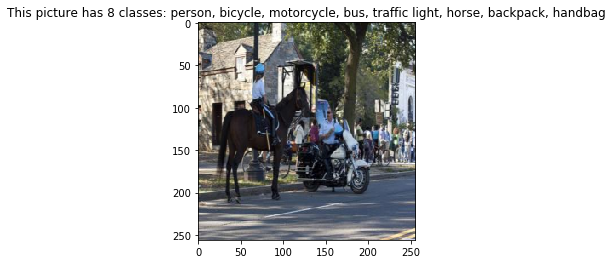

In [20]:
import matplotlib.pyplot as plt

plt.figure()
#Running this multiple times will show data augmentation / transformation
x,y,_ = train_dataset[1001] #x is the image - transformed to tensor later, y is the class vector, _ is the filename
labels = [train_dataset.classes[id] for id in list(y.nonzero().flatten())] #y is a sparse vector. Could have multiclass
plt.title(f'This picture has {len(labels)} classes: {", ".join(labels)}')


# Undo normalization of the pixel values.
for t, m, s in zip(x, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
    t.mul_(s).add_(m)
# Re-arrange dimensions so it is height x width x channels.
plt.imshow(x.transpose(0, 2).transpose(0, 1))
plt.grid(False)
plt.axis('on')


#### Define and train a model for this task [30pts]

##### Finetuning ResNet


In [21]:
import torchvision.models as models
import torch.nn as nn

#load alexnet with pretrained weights
model = models.resnet50(pretrained = True)

#Let's freeze params for all layers before chopping off tail
#faster prototyping and likely better performance using pretrained weights
for param in model.parameters():
    param.requires_grad = False


# print('-' * 50)
# print('resnet50 Architecture \n', model)
model.fc = nn.Linear(2048,80)
# print('-' * 50)
# print('resnet50 Architecture Revised \n', model)


# pytorch_total_params = sum(p.numel() for p in model.parameters())
# print('-' * 50)
# print(f'total params = {pytorch_total_params}')

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
# params = sum([np.prod(p.size()) for p in model_parameters])
# print(f'trainable params = {params}')


#!pip install torchsummary
from torchsummary import summary
summary(model.cuda(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [22]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import torch.optim as optim

# Pytorch DataLoader for iterating over batches.
batchSize = 100

# Create the model.
loss_fn = nn.BCEWithLogitsLoss()

# Define a learning rate.
learningRate = .01

# Optimizer.
optimizer = optim.SGD(model.parameters(),
                      lr=learningRate,
                      momentum=0.9,
                      weight_decay=1e-4)

#!pip install pytorch-nlp
#from torchnlp.utils import torch_equals_ignore_index

#### Top K Accuracy
We'll be computing top-k accuracy in two different ways below.
The first way follows Lecture Slides 7, which was noted as being invalid for multi-label classification tasks. Here, we just look at the $y_{pred} \cap y_{true}$ and if the the length of this intersection is non-empty, then we increment the 'correct' counter by 1.

Perhaps, however, we are to look to increment correct by $|y_{pred} \cap y_{true}|$ and have accuracy be computed against k, a la Accuracy = $\frac{1}{n*k}\sum_{i=1}^n  |y^{hat}_{i} \cap y^{true}_{i}|$


In [511]:
def train_model(model, loss_fn, batchSize, trainset, valset, optimizer,
                num_epochs):

    # Shuffling is needed in case dataset is not shuffled by default.
    train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                               batch_size=batchSize,
                                               shuffle=True)
    # We don't need to bach the validation set but let's do it anyway.
    val_loader = torch.utils.data.DataLoader(dataset=valset,
                                             batch_size=batchSize,
                                             shuffle=False)  # No need.

    # Define number of epochs.
    N = num_epochs
    k = 3
    # log accuracies and losses.
    train_accuracies = []
    val_accuracies = []
    train_accuracies_v2 = []
    val_accuracies_v2 = []
    train_losses = []
    val_losses = []

    # GPU enabling.
    model = model.cuda(device=0)
    loss_fn = loss_fn.cuda(device=0)
    #------------------------------------------------------------------------------------#
    # Training loop. Please make sure you understand every single line of code below.
    #------------------------------------------------------------------------------------#
    for epoch in range(0, N):
        correct = 0.0
        top_kcorrect = 0.0
        cum_loss = 0.0
        
        #------------------------------------------------------------------------------------#
        #batch training. Train mode on 
        #------------------------------------------------------------------------------------#
        model.train()
        for (i, (inputs, labels, _)) in enumerate(train_loader):
            inputs = inputs.cuda(device=0)
            labels = labels.cuda(device=0)

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            loss = loss_fn(scores, labels)
            cum_loss += loss.item()

            #------------------------------------------------------------------------------------#
            #Compute top-k accuracy two ways
            #------------------------------------------------------------------------------------#

            for labs, score in zip(labels, scores):
                true_labels = ((labs.squeeze(0) == 1).nonzero()).flatten(
                ).detach().cpu().clone().numpy()  #flatten list of true labels
                top_k_preds = score.topk(k)[-1].flatten().detach().cpu().clone(
                ).numpy()  #flatten top k prediction
                intersect = np.intersect1d(true_labels, top_k_preds)
                if len(intersect) != 0:
                    correct += 1
                    top_kcorrect += len(intersect)

            # Zero the gradients in the network.
            optimizer.zero_grad()

            #Backward pass. (Gradient computation stage)
            loss.backward()

            # Parameter updates (SGD step) -- if done with torch.optim!
            optimizer.step()

        #------------------------------------------------------------------------------------#
        #Train Logging
        #------------------------------------------------------------------------------------#
            if (i + 1) % 100 == 0:
                print(
                    'Train-epoch %d. Iteration %05d / %05d, Avg-Loss: %.4f, Top 3 Accuracy (v1): %.4f, Top 3 Accuracy (v2): %.4f'
                    % (epoch, i + 1, len(train_loader), cum_loss /
                       (i + 1), correct / ((i + 1) * batchSize), top_kcorrect / ((i + 1) * batchSize * k)))


        train_accuracies.append(correct / len(trainset))
        train_accuracies_v2.append(top_kcorrect / (len(trainset)*k))
        train_losses.append(cum_loss / (i + 1))
    #------------------------------------------------------------------------------------#
        # VALI LOOP. Eval Mode on
    #------------------------------------------------------------------------------------#

        correct = 0.0
        top_kcorrect = 0.0
        cum_loss = 0.0
        model.eval()
        for (i, (inputs, labels, _)) in enumerate(val_loader):
            inputs = inputs.cuda(device=0)
            labels = labels.cuda(device=0)

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            cum_loss += loss_fn(scores, labels).item()

            #------------------------------------------------------------------------------------#
            #Compute top-k accuracy two ways
            #------------------------------------------------------------------------------------#
            for labs, score in zip(labels, scores):
                true_labels = ((labs.squeeze(0) == 1).nonzero()).flatten(
                ).detach().cpu().clone().numpy()  #flatten list of true labels
                top_k_preds = score.topk(3)[-1].flatten().detach().cpu().clone(
                ).numpy()  #flatten top k prediction
                intersect = np.intersect1d(true_labels, top_k_preds)
                if len(intersect) != 0:
                    correct += 1
                    top_kcorrect += len(intersect)

        val_accuracies.append(correct / len(valset))
        val_accuracies_v2.append(top_kcorrect / (len(valset)*k))
        val_losses.append(cum_loss / (i + 1))

        #------------------------------------------------------------------------------------#
        #Vali Logging
        #------------------------------------------------------------------------------------#
        print('Validation-epoch %d. Avg-Loss: %.4f, Top 3 Accuracy (v1): %.4f, Top 3 Accuracy (v2): %.4f' %
              (epoch, cum_loss / (i + 1), correct / len(valset), top_kcorrect / (len(valset)*k)))
    return train_losses, val_losses, train_accuracies, val_accuracies, train_accuracies_v2, val_accuracies_v2

In [512]:
trained = True

if not trained:
    train_losses, val_losses, train_accuracies, val_accuracies, train_accuracies_v2, val_accuracies_v2 = train_model(
        model=model,
        loss_fn=loss_fn,
        batchSize=batchSize,
        trainset=train_dataset,
        valset=val_dataset,
        optimizer=optimizer,
        num_epochs=10)

    torch.save(model.state_dict(), 'resnetcoco_weights.pth')
else:

    model.load_state_dict(torch.load('resnetcoco_weights.pth'))

Train-epoch 0. Iteration 00100 / 00828, Avg-Loss: 0.0690, Top 3 Accuracy (v1): 0.9563, Top 3 Accuracy (v2): 0.5811
Train-epoch 0. Iteration 00200 / 00828, Avg-Loss: 0.0689, Top 3 Accuracy (v1): 0.9570, Top 3 Accuracy (v2): 0.5796
Train-epoch 0. Iteration 00300 / 00828, Avg-Loss: 0.0690, Top 3 Accuracy (v1): 0.9570, Top 3 Accuracy (v2): 0.5800
Train-epoch 0. Iteration 00400 / 00828, Avg-Loss: 0.0691, Top 3 Accuracy (v1): 0.9578, Top 3 Accuracy (v2): 0.5804
Train-epoch 0. Iteration 00500 / 00828, Avg-Loss: 0.0688, Top 3 Accuracy (v1): 0.9580, Top 3 Accuracy (v2): 0.5800
Train-epoch 0. Iteration 00600 / 00828, Avg-Loss: 0.0688, Top 3 Accuracy (v1): 0.9587, Top 3 Accuracy (v2): 0.5806
Train-epoch 0. Iteration 00700 / 00828, Avg-Loss: 0.0687, Top 3 Accuracy (v1): 0.9589, Top 3 Accuracy (v2): 0.5805
Train-epoch 0. Iteration 00800 / 00828, Avg-Loss: 0.0689, Top 3 Accuracy (v1): 0.9588, Top 3 Accuracy (v2): 0.5807
Validation-epoch 0. Avg-Loss: 0.0681, Top 3 Accuracy (v1): 0.9576, Top 3 Accurac

#### Top k accuracy as the presence of a true label in any of the top 3 predictions

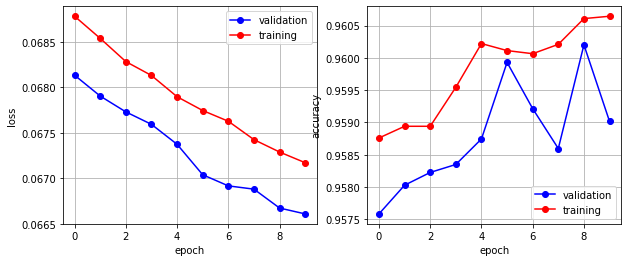

max validation accuracy: 96.02 ; Epochs: 8 


In [513]:
# Your code for visualizing train/val plots for accuracy and losses.
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, 'bo-', label='val-loss')
plt.plot(train_losses, 'ro-', label='train-loss')
plt.grid('on')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'bo-', label='val-acc')
plt.plot(train_accuracies, 'ro-', label='train-acc')
plt.ylabel('accuracy')
plt.grid('on')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()

print('max validation accuracy: %.2f ; Epochs: %.0f ' % (max(val_accuracies) * 100, np.argmax(val_accuracies)))

#### Top k accuracy as Accuracy = $\frac{1}{n*k}\sum_{i=1}^n  |y^{hat}_{i} \cap y^{true}_{i}|$


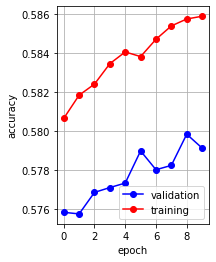

max validation accuracy: 57.98 ; Epochs: 8 


In [514]:
# Your code for visualizing train/val plots for accuracy and losses.
plt.subplot(1, 2, 2)
plt.plot(val_accuracies_v2, 'bo-', label='val-acc')
plt.plot(train_accuracies_v2, 'ro-', label='train-acc')
plt.ylabel('accuracy')
plt.grid('on')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()

print('max validation accuracy: %.2f ; Epochs: %.0f ' % (max(val_accuracies_v2) * 100, np.argmax(val_accuracies_v2)))

#### Show some predictions of our model on some images [10pts].

Run your predictions on the images [2348, 13134, 22313, 4123] in the dataset. I'm showing you here the output that I obtained with my model. Show what your model does here.

We use top-k method #2 here: Accuracy = $\frac{1}{n*k}\sum_{i=1}^n  |y^{hat}_{i} \cap y^{true}_{i}|$. This was the accuracy type that was hardcoded into the assignment template.

--------------------------------------------------
showing image number 2348 from val set


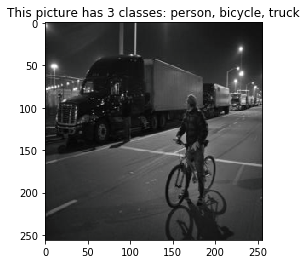

y_hat[person]: 2.37
y_hat[bicycle]: 0.20
y_hat[car]: -0.03
Accuracy of top-3 predictions: 0.67
What I think top-3 accuracy should be here: 0.67
--------------------------------------------------
--------------------------------------------------
showing image number 13134 from val set


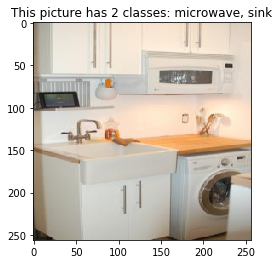

y_hat[oven]: 2.90
y_hat[sink]: 2.73
y_hat[microwave]: 1.54
Accuracy of top-3 predictions: 0.67
What I think top-3 accuracy should be here: 1.00
--------------------------------------------------
--------------------------------------------------
showing image number 22313 from val set


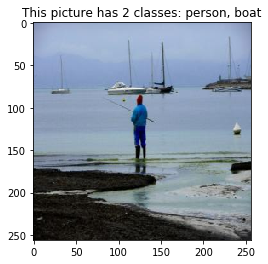

y_hat[person]: 2.30
y_hat[boat]: 1.28
y_hat[surfboard]: -1.43
Accuracy of top-3 predictions: 0.67
What I think top-3 accuracy should be here: 1.00
--------------------------------------------------
--------------------------------------------------
showing image number 4123 from val set


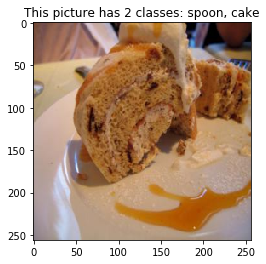

y_hat[cake]: 2.07
y_hat[dining table]: 0.65
y_hat[sandwich]: 0.51
Accuracy of top-3 predictions: 0.33
What I think top-3 accuracy should be here: 0.50
--------------------------------------------------


In [25]:
def plot_image(img):
    print('-' * 50)
    print(f'showing image number {img} from val set')
    plt.figure()
    #Running this multiple times will show data augmentation / transformation
    x, y, _ = val_dataset[
        img]  #x is the image - transformed to tensor later, y is the class vector, _ is the filename
    labels = [val_dataset.classes[id] for id in list(y.nonzero().flatten())
              ]  #y is a sparse vector. Could have multiclass
    plt.title(f'This picture has {len(labels)} classes: {", ".join(labels)}')

    # Undo normalization of the pixel values.
    for t, m, s in zip(x, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)
    # Re-arrange dimensions so it is height x width x channels.
    plt.imshow(x.transpose(0, 2).transpose(0, 1))
    plt.grid(False)
    plt.axis('on')
    plt.show()

    model.eval()
    preds = model(val_dataset[img][0].unsqueeze(0).cuda(device=0))
    #     true_labels = val_dataset[img][1]

    top_k = preds.topk(3)
    #     true_labels = [train_dataset.classes[id] for id in list(true_labels.nonzero().flatten())]

    predicted_labels = [
        train_dataset.classes[id] for id in list(top_k.indices.flatten())
    ]
    pred_prob = preds.topk(3).values.squeeze()

    for i, j in zip(predicted_labels, pred_prob):
        print(f'y_hat[{i}]: {j:.2f}')

    np_true = y.nonzero().flatten().detach().cpu().clone().numpy()
    np_top_preds = top_k.indices.flatten().detach().cpu().clone().numpy()
    intersect = np.intersect1d(np_true, np_top_preds)

    print(f'Accuracy of top-3 predictions: {len(intersect) / 3:.2f}')
    print(f'What I think top-3 accuracy should be here: {len(intersect) / min(len((np_true)),3):.2f}')
    print('-' * 50)
              


for i in [2348, 13134, 22313, 4123]:
    plot_image(img=i)

### 2. Batch-Normalization + Max-Pool Removal [20pts]. 


Below is the implementation of Alexnet included in pytorch, after this network was released in NeurIPS 2012, several other ideas regarding individual layers were introduced to make models better. In this section, modify the code of Alexnet so that it uses BatchNormalization layers (Ioffe and Szegedy https://arxiv.org/abs/1502.03167) after each convolutional layer. You don't need to implement a BatchNorm layer, just use the one included in Pytorch. In another network such as the VGG Network (https://arxiv.org/abs/1409.1556), it was shown that one does not need to use max-pooling layers after all convolutional layers, remove all the max-pooling layers of Alexnet so that this is still a valid network. **Note:** You don't need to train this model.

#### Removing Pooling Layers adding Batchnorm

In [252]:
#Can adjust kernel/stride/padding, but wanted to keep the underlying architecture params
#Removed maxpooling and added 2d batchnorm
#size mismatch after feature extraction
#expand linear layer nhidden
#resize into 256 * 55 *55 after feature extraction
#feed into fully connected layers
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            #             nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            #             nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), # 256 * 55 * 55
            #             nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 55 * 55, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 55 * 55)
        x = self.classifier(x)
        return x


# TEST: This should still work after the two required modifications.
# The output should be a tensor of size batchSize x numPredictions
mock_input_batch = torch.zeros(10, 3, 224, 224).normal_(0, 0.01)

alexnet = AlexNet()
alexnet.eval()

print('input_batch.shape:', mock_input_batch.shape)
scores = alexnet(mock_input_batch)
print('scores.shape:', scores.shape)
#summary(alexnet.cuda(), (3, 224, 224))

# alexnet.features(mock_input_batch).size()

input_batch.shape: torch.Size([10, 3, 224, 224])
scores.shape: torch.Size([10, 1000])


#### Keeping Pooling Layers adding Batchnorm

In [247]:
#Can adjust kernel/stride/padding, but wanted to keep the underlying architecture params
#Removed maxpooling and added 2d batchnorm
#size mismatch after feature extraction
#expand linear layer nhidden
#resize into 256 * 55 *55 after feature extraction
#feed into fully connected layers
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), # 256 * 5 * 5
                        nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


# TEST: This should still work after the two required modifications.
# The output should be a tensor of size batchSize x numPredictions
mock_input_batch = torch.zeros(10, 3, 224, 224).normal_(0, 0.01)

alexnet = AlexNet()
alexnet.eval()

print('input_batch.shape:', mock_input_batch.shape)
scores = alexnet(mock_input_batch)
print('scores.shape:', scores.shape)

# alexnet.features(mock_input_batch).size()
summary(alexnet.cuda(), (3, 224, 224))

input_batch.shape: torch.Size([10, 3, 224, 224])
scores.shape: torch.Size([10, 1000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
       BatchNorm2d-2           [-1, 64, 55, 55]             128
              ReLU-3           [-1, 64, 55, 55]               0
         MaxPool2d-4           [-1, 64, 27, 27]               0
            Conv2d-5          [-1, 192, 27, 27]         307,392
       BatchNorm2d-6          [-1, 192, 27, 27]             384
              ReLU-7          [-1, 192, 27, 27]               0
         MaxPool2d-8          [-1, 192, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         663,936
      BatchNorm2d-10          [-1, 384, 13, 13]             768
             ReLU-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 256, 13, 13]         884,992
      BatchNorm2d

### 3. Skip-Connections (Residuals) + Inception Layers [20pts]. 


Below is the implementation of Alexnet included in pytorch, after this network was released in NeurIPS 2012, several other ideas regarding architectural changes were introduced to make models better. Modify the code of AlexNet below so that it has a skip connection between the third and fifth convolutional layer (see ResNet by He et al https://arxiv.org/abs/1512.03385 ). Additionally, replace the second convolutional layer with an Inception Layer that has three branches, each using filters of different size (see Inception_v3 by Szegedy et al https://arxiv.org/abs/1512.00567 ). **Note:** You don't need to train this model.

In [445]:
#https://engmrk.com/residual-networks-resnets/
#https://stats.stackexchange.com/questions/264867/shortcut-connections-in-resnet-with-different-spatial-sizes


#Some slight modifications to in/out channel sizes to make this work.
#I think this would have easier without the Sequential Wrapper
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            #-------------------------------------------------------#
            #BLOCK 1
            #-------------------------------------------------------#

            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,
                         stride=2),  #torch.Size([10, 192, 27, 27])
            #-------------------------------------------------------#
            #BLOCK 2
            ##INCEPTION BLOCK##
            #Different filter sizes on all branches
            #Had to tinker with in/out channels to get size match
            #-------------------------------------------------------#

            nn.Conv2d(64, 64, kernel_size=1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            #concat filters here
            ##INCEPTION BLOCK##

            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  #[10, 448, 13, 13]
            #-------------------------------------------------------#
            #BLOCK 3
            #-------------------------------------------------------#

            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #-------------------------------------------------------#
            #BLOCK 4
            #-------------------------------------------------------#

            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #-------------------------------------------------------#
            #BLOCK 5
            #-------------------------------------------------------#

            #Add output of block3 with output of block 4 for skip connections.
            #This will be fed into Block 5 as input. Identity Mapping
            nn.Conv2d(
                192, 256, kernel_size=3, padding=1
            ),  #change outchannels to match conv#3 outchannels. Otherwise we need t 
            nn.ReLU(
                inplace=True
            ),  #to add a shortcut convolution layer to resize to appropriate
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    #http://torch.ch/blog/2016/02/04/resnets.html
    def forward(self, x):
        x = self.features[:3](x)
        #---------------------------------------------#
        #####INCEPTION BLOCK######
        #https://arxiv.org/pdf/1512.00567.pdf
        #---------------------------------------------#
        conv_21 = self.features[3](x)
        conv_22 = self.features[4](x)

        conv_23 = self.features[5](x)
        in_inception = torch.cat((conv_21, conv_22, conv_23), dim=1)

        out_inception = self.features[6:8](in_inception)
        #---------------------------------------------#
        #####SKIP Connection Between Conv #3 and Conv #5######
        #https://arxiv.org/pdf/1512.03385.pdf
        #---------------------------------------------#
        conv3_out = self.features[8:10](
            out_inception)  #extract features outputted up to conv #3

        conv4_out = self.features[10:12](
            conv3_out)  #extract features outpuuted @ conv #4
        skip = torch.add(conv3_out, conv4_out)  #add layers together
        #Run COnv4 on SKip inputs
        x = self.features[12:](skip)
        x = x.view(x.size(0), 256 * 6 * 6)
        #---------------------------------------------#
        #Fully Connected
        #---------------------------------------------#
        x = self.classifier(x)
        return x


# TEST: This should still work after the two required modifications.
# The output should be a tensor of size batchSize x numPredictions
mock_input_batch = torch.zeros(10, 3, 224, 224).normal_(0, 0.01)

alexnet = AlexNet()
alexnet.eval()

print('input_batch.shape:', mock_input_batch.shape)
scores = alexnet(mock_input_batch)
print('scores.shape:', scores.shape)


input_batch.shape: torch.Size([10, 3, 224, 224])
scores.shape: torch.Size([10, 1000])


### 4. Literature Review [20pts]
What is the maximum accuracy reported in the recent literature for the MIT Indoor Scenes dataset and what method was used? How does the accuracy that we obtained in this notebook compare?  

To recap, we fine-tuned Resnet50 on the MIT Indoor Scenes dataset by chopping off the last fully connected layer and retraining the entire model w/ the updated output length corresponding to this specific dataset - There are 67 classes here. Our model had 23645315 total parameters, all of which were trainable. We likely should have frozen all layers' weights leading up to the last FC layer - as we did in this final task - to retain the information learned when the original RESNET50 model was trained at scale. We only trained for 10 total epochs and achieved a max validation accuracy of 70% flat. This was done in the tutorial, so I didn't adjust any hyperparams here. Bayesian hyperparam search, or even grid search, can be prove accuracy to be highly elastic. 2009 was before the deep learning craze, so the initial paper on distance / metric-learning as opposed to network depth or width. The original paper used average precision as their metric to measure success, which was further defined as being the mean over diagonal values of a confusion matrix generated by average multiclass prediction accuracy[1]. This is a bit different than what we used to measure performance in our experiments. Let's find some more recent papers. [2] used multi-class SVMS, but didn't train on the full dataset - Their objective was different, and they measured an accuract of ~60%. [3] is a great benchmark, not because it's heavily cited, but because it is claimed that their method achieves all-time state of the art on the MIT 67 dataset, and because it was published just last year. The idea is quite novel, actually, as they describe two networks each extracting total or partial features for an image and then molding them together in what they call a trainable fusion module. The table below is extracted from their paper, and we'll go through some of the other models/methods that performed comparably on MIT67.

![alt text](MIT67_SOTA.png "Title")


[4], the next highest validation accuracy on this dataset, as well as some other impressive accuracies in other image recognition datasets like SUN397 and PLACES365. This method also looks into this idea of fusing representations using a number of discriminative models, extract different features for each relating to object semantics, global appearance and contextual appearance. [5] was published in 2017 and also uses some form of CNNs. This paper looked into this idea of constructing a global representation of the feature map and then striding over the window dimensions to convey information regarding the 'constituent objects' of the scenes. So their representation was local in focus, as it pondered a scene as a composition of the objects that make up the scene. This is interesting. They reported final classificatiton accuracy of 87.22% on the MIT67 dataset, and 95.73% on the Scene15 dataset. [6] was published in 2018 and measured 86.76% accuracy on the MIT67 validation set. Their method also looks into this idea of fusion. As they note, they use a number of feature extractors (built on deep CNNs) to generate local and global representations and then concatenate the results. They also note that they make use of pretrained models via imagenet and place205. These papers had a similar focus in this idea of a concatenation of local and global representations

The accuracy that we obtained here was 87%, borrowing the architecture of ResNet. It is interesting how well this stacks up against the literature up to 2019, especially considering that we were limited in gpu-compute and only trained the model for a small number of iterations. Architecture with skip/residual connections are becoming the norm for object detection / image classification, so I'm curious if all of these methods utilized architectures that employed these kinds of layers, or if any of the other state of the art methods in optimization algorithms or learning rate scheduling helped us to perform comparably. It should also be noted that many of these methods used transfer learning, i.e. models w/ pretrained weights on large image recognition datasets. Most of the time, it appears, the last layers were chopped off to accomodate for a different datasets' labels, similar to what we did here in the tutorial. Most of these state of the art accuracies also noted employing a standard 80/20 train test split, but its unclear if that's exactly the same train test split that was noted here. 




References:

[1] A. Quattoni, and A.Torralba. Recognizing Indoor Scenes. IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2009.

[2] Bala, Neetu, and Harpreet Singh. "Adaptive Indoor Scene Classification with Multi-SVM Classification to solve Multi-Class Problem." International Journal 7.2 (2017).

[3] Seong, Hongje, Junhyuk Hyun, and Euntai Kim. "FOSNet: An End-to-End Trainable Deep Neural Network for Scene Recognition." arXiv preprint arXiv:1907.07570 (2019).

[4] N. Sun, W. Li, J. Liu, G. Han, and C. Wu, “Fusing object semantics and
deep appearance features for scene recognition,” IEEE Transactions on
Circuits and Systems for Video Technology, 2018.

[5] Nascimento, Guilherme, et al. "A robust indoor scene recognition method based on sparse representation." Iberoamerican Congress on Pattern Recognition. Springer, Cham, 2017.

[6] X. Cheng, J. Lu, J. Feng, B. Yuan, and J. Zhou, “Scene recognition with
objectness,” Pattern Recognition, vol. 74, pp. 474–487, 2018.